In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import warnings
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFECV
from catboost import CatBoostClassifier

plt.style.use('seaborn-bright')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [121]:
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

In [ ]:
train_data.info()

In [ ]:
train_data.describe()

In [ ]:
train_data.head()

In [122]:
combine_data = [train_data, test_data]
for df in combine_data:
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand = True)
    df[['PGroup','PNr']] = df['PassengerId'].str.split('_', expand=True)

    df['Num'] = df['Num'].astype('float')
    df['PNr'] = df['PNr'].astype('float')
    df['PGroup'] = df['PGroup'].astype('float')

train_data[['Deck', 'Num', 'Side', 'PGroup', 'PNr']].head()

,Deck,Num,Side,PGroup,PNr
0,B,0.0,P,1.0,1.0
1,F,0.0,S,2.0,1.0
2,A,0.0,S,3.0,1.0
3,A,0.0,S,3.0,2.0
4,F,1.0,S,4.0,1.0


In [123]:
combine_data = [train_data, test_data]
for data in combine_data:
    data.Num = data.Num.astype('float64')
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,PGroup,PNr
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,1.0,1.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,2.0,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,3.0,1.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,3.0,2.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,4.0,1.0


In [ ]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 240
sns.set_theme(style="darkgrid")

In [ ]:

plt.title("Age in counts")
sns.histplot(data=train_data, x="Age")
plt.savefig('img/5.png')

In [ ]:
train_data[train_data['Age']<1]

In [ ]:
plt.title("Age histogram")
sns.histplot(data=train_data, x="Age", binwidth=5)
plt.savefig('img/6.png')

In [ ]:
plt.title("Age histogram")
sns.histplot(data=train_data, x="Age", binwidth=5, kde=True)
plt.savefig('img/7.png')

In [ ]:
train_data["Age"].skew()

In [ ]:
plt.title("FoodCourt histogram")
sns.histplot(data=train_data, x="FoodCourt", bins=30)
plt.savefig('img/8.png')

In [ ]:
tmp_df = train_data[["FoodCourt"]] + 1
plt.title("Age in counts")
sns.histplot(data=tmp_df, x="FoodCourt", bins=30, log_scale=True)
plt.savefig('img/9.png')

In [ ]:
plt.title("Age in counts")
sns.histplot(data=train_data[train_data["FoodCourt"]!=0], x="FoodCourt", bins=30, log_scale=True)
plt.savefig('img/10.png')

In [ ]:
train_data[train_data["FoodCourt"]!=0]["FoodCourt"].skew()

In [ ]:
sns.histplot(data=train_data, x="Num", hue='Transported')
plt.savefig('img/11.png')

In [ ]:
columns=['Age', 'Num', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
row, col = divmod(len(columns), 3)
fig, ax = plt.subplots(row + 1, 3, figsize=(16,14))
for idx, column in enumerate(columns):
    row, col = divmod(idx, 3)
    if column in ['Age', 'Num']:
        sns.histplot(data=train_data, x=column, hue='Transported', ax=ax[row, col], kde=True, bins=30)
    else:
        tmp_df = train_data[[column]] + 1
        tmp_df['Transported'] = train_data['Transported']
        sns.histplot(data=tmp_df, x=column, hue='Transported', ax=ax[row, col], log_scale=True, kde=True, bins=30)
plt.savefig('img/12.png', bbox_inches='tight', pad_inches = 0.2)

In [ ]:
plt.title("HomePlanet in counts")
sns.countplot(data=train_data, x="HomePlanet")
plt.savefig('img/13.png')

In [ ]:
plt.title("HomePlanet in counts")
sns.countplot(data=train_data, x="HomePlanet", hue="Transported")
plt.savefig('img/14.png')

In [ ]:
columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
row, col = divmod(len(columns), 3)
fig, ax = plt.subplots(row, 3, figsize=(16,7))
for idx, column in enumerate(columns):
    row, col = divmod(idx, 3)
    sns.countplot(data=train_data, x=column, hue='Transported', ax=ax[row, col])
plt.savefig('img/15.png', bbox_inches='tight', pad_inches = 0.2)

In [ ]:
plt.title("Transported in counts")
sns.countplot(data=train_data, x="Transported")
plt.savefig('img/16.png')

In [ ]:
plt.title("Age Box Plot")
sns.boxplot(data=train_data, x="Age")
plt.savefig('img/17.png')

In [ ]:
columns=['Age', 'Num', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
row, col = divmod(len(columns), 3)
fig, ax = plt.subplots(row + 1, 3, figsize=(16,12))
for idx, column in enumerate(columns):
    row, col = divmod(idx, 3)
    sns.boxplot(data=train_data, x=column, ax=ax[row, col])
plt.savefig('img/18.png', bbox_inches='tight', pad_inches = 0.2)

In [ ]:
sns.scatterplot(data=train_data, x="RoomService", y="FoodCourt")
plt.savefig('img/19.png')

In [ ]:
sns.scatterplot(data=train_data, x="RoomService", y="FoodCourt", hue="Transported")
plt.savefig('img/20.png')

In [ ]:
sns.scatterplot(data=train_data, x="RoomService", y="FoodCourt", hue="Destination")

In [ ]:
sns.pairplot(train_data[['Age', 'Num', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', "Transported"]], hue="Transported")
plt.savefig('img/21.png')

In [ ]:
train_data.corr()

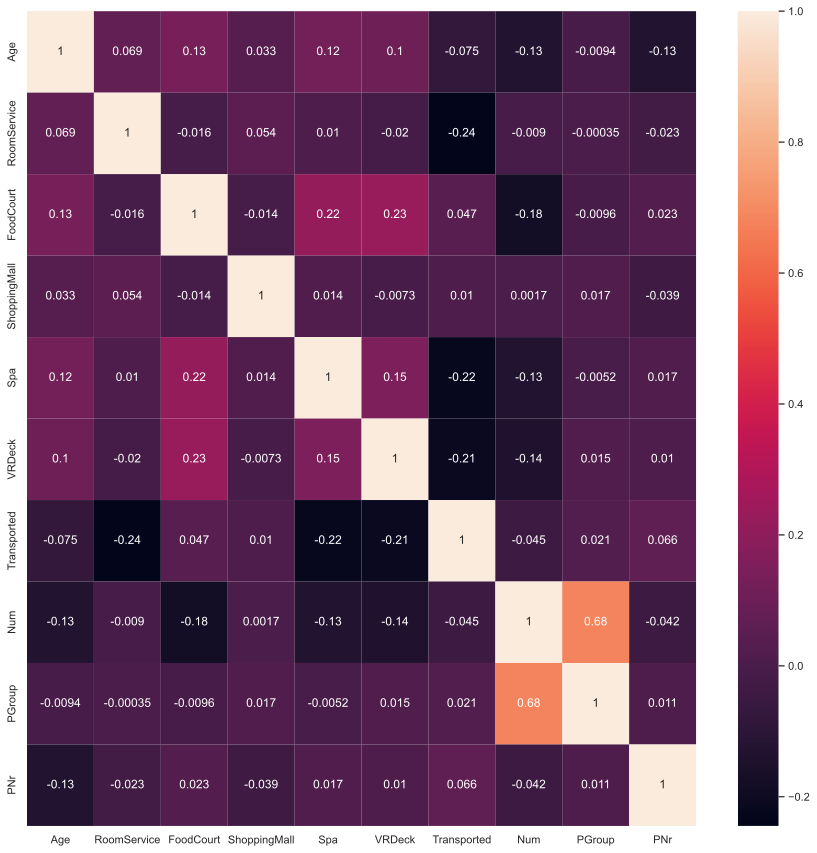

In [110]:
plt.figure(figsize=(15,15))
sns.heatmap(train_data.corr(), annot=True)
plt.savefig('img/23.png', bbox_inches='tight', pad_inches = 0.2)

In [129]:
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Num             199
Side            199
PGroup            0
PNr               0
dtype: int64

In [125]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Deck          8494 non-null   object 
 15  Num           8494 non-null   float64
 16  Side          8494 non-null   object 
 17  PGroup        8693 non-null   float64
 18  PNr           8693 non-null 

In [114]:
train_data.select_dtypes(object)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Deck,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,B,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,F,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,A,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,A,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,F,S
...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,True,Gravior Noxnuther,A,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,False,Kurta Mondalley,G,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,False,Fayey Connon,G,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,False,Celeon Hontichre,E,S


In [141]:
import time
df = train_data.copy()
start = time.time()
numeric_tmp = df.select_dtypes(include = np.number)
categorical_tmp = df.select_dtypes(include = object)

for col in numeric_tmp.columns:
    df[col] = df[col].fillna(value = df[col].mean())

for col in categorical_tmp.columns:
    df[col] = df[col].fillna(value = df[col].mode()[0])
print(time.time() - start)
    
df.mean()

0.04715275764465332


PassengerId             inf
CryoSleep          0.349362
Age               28.827930
VIP                0.022892
RoomService      224.687617
FoodCourt        458.077203
ShoppingMall     173.729169
Spa              311.138778
VRDeck           304.854791
Transported        0.503624
Num              600.367671
PGroup          4633.389624
PNr                1.517773
dtype: float64

In [156]:
train_data[train_data.isnull().T.any()].select_dtypes(include = np.number).head(10)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,PGroup,PNr
7,28.0,0.0,0.0,0.0,0.0,NaN,0.0,6.0,2.0
10,34.0,0.0,0.0,NaN,0.0,0.0,1.0,8.0,2.0
15,31.0,32.0,0.0,876.0,0.0,0.0,NaN,12.0,1.0
16,27.0,1286.0,122.0,NaN,0.0,0.0,3.0,14.0,1.0
23,29.0,0.0,0.0,NaN,0.0,0.0,0.0,20.0,3.0
25,1.0,NaN,0.0,0.0,0.0,0.0,0.0,20.0,5.0
27,21.0,980.0,2.0,69.0,0.0,0.0,0.0,22.0,1.0
28,62.0,0.0,0.0,NaN,0.0,0.0,2.0,24.0,1.0
35,20.0,NaN,0.0,1750.0,990.0,0.0,9.0,31.0,3.0
38,15.0,0.0,492.0,48.0,20.0,401.0,8.0,36.0,1.0


In [154]:
df[train_data.isnull().T.any()].select_dtypes(include = np.number).head(10)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,PGroup,PNr
7,28.0,0.000000,0.0,0.000000,0.0,304.854791,0.000000,6.0,2.0
10,34.0,0.000000,0.0,173.729169,0.0,0.000000,1.000000,8.0,2.0
15,31.0,32.000000,0.0,876.000000,0.0,0.000000,600.367671,12.0,1.0
16,27.0,1286.000000,122.0,173.729169,0.0,0.000000,3.000000,14.0,1.0
23,29.0,0.000000,0.0,173.729169,0.0,0.000000,0.000000,20.0,3.0
25,1.0,224.687617,0.0,0.000000,0.0,0.000000,0.000000,20.0,5.0
27,21.0,980.000000,2.0,69.000000,0.0,0.000000,0.000000,22.0,1.0
28,62.0,0.000000,0.0,173.729169,0.0,0.000000,2.000000,24.0,1.0
35,20.0,224.687617,0.0,1750.000000,990.0,0.000000,9.000000,31.0,3.0
38,15.0,0.000000,492.0,48.000000,20.0,401.000000,8.000000,36.0,1.0


In [127]:
train_data.mean()

PassengerId             inf
CryoSleep          0.358306
Age               28.827930
VIP                0.023439
RoomService      224.687617
FoodCourt        458.077203
ShoppingMall     173.729169
Spa              311.138778
VRDeck           304.854791
Transported        0.503624
Num              600.367671
PGroup          4633.389624
PNr                1.517773
dtype: float64

In [133]:
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Num             199
Side            199
PGroup            0
PNr               0
dtype: int64

In [155]:
from sklearn.impute import SimpleImputer
start = time.time()

df2 = train_data.select_dtypes(include = np.number)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(df2)

df2 = pd.DataFrame(imp_mean.transform(df2), columns = train_data.select_dtypes(include = np.number).columns)

print(time.time() - start)
df2[train_data.isnull().T.any()].head(10)

0.010727882385253906


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,PGroup,PNr
7,28.0,0.000000,0.0,0.000000,0.0,304.854791,0.000000,6.0,2.0
10,34.0,0.000000,0.0,173.729169,0.0,0.000000,1.000000,8.0,2.0
15,31.0,32.000000,0.0,876.000000,0.0,0.000000,600.367671,12.0,1.0
16,27.0,1286.000000,122.0,173.729169,0.0,0.000000,3.000000,14.0,1.0
23,29.0,0.000000,0.0,173.729169,0.0,0.000000,0.000000,20.0,3.0
25,1.0,224.687617,0.0,0.000000,0.0,0.000000,0.000000,20.0,5.0
27,21.0,980.000000,2.0,69.000000,0.0,0.000000,0.000000,22.0,1.0
28,62.0,0.000000,0.0,173.729169,0.0,0.000000,2.000000,24.0,1.0
35,20.0,224.687617,0.0,1750.000000,990.0,0.000000,9.000000,31.0,3.0
38,15.0,0.000000,492.0,48.000000,20.0,401.000000,8.000000,36.0,1.0


In [208]:
from sklearn.impute import SimpleImputer
start = time.time()

df_numeric = df.select_dtypes(include = np.number)
df_categorical = df.select_dtypes(include = object)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(df_numeric)
values = imputer.transform(df_numeric)
df_numeric = pd.DataFrame(values, columns = df_numeric.columns)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(df_categorical)
values = imputer.transform(df_categorical)
df_categorical = pd.DataFrame(values, columns = df_categorical.columns)

pd.concat([df_numeric, df_categorical], axis = 1)[train_data.isnull().T.any()]

In [171]:
from sklearn.impute import KNNImputer

x = [[1, np.nan, 5], [1, 0, 0], [3, 3, 3]]

imputer = KNNImputer(n_neighbors = 1)
print(imputer.fit_transform(x))

imputer = KNNImputer(n_neighbors = 2)
print(imputer.fit_transform(x))

x = [[1, np.nan, 5], [1, 0, np.nan], [3, 3, 3]]

imputer = KNNImputer(n_neighbors = 1)
print(imputer.fit_transform(x))

[[1. 3. 5.]
 [1. 0. 0.]
 [3. 3. 3.]]
[[1.  1.5 5. ]
 [1.  0.  0. ]
 [3.  3.  3. ]]
[[1. 0. 5.]
 [1. 0. 5.]
 [3. 3. 3.]]


In [174]:
from sklearn.impute import KNNImputer
start = time.time()

df3 = train_data.select_dtypes(include = np.number)
imputer = KNNImputer(n_neighbors = 1)
imputer.fit(df3)

df3 = pd.DataFrame(imputer.transform(df3), columns = train_data.select_dtypes(include = np.number).columns)

print(time.time() - start)
df3[train_data.isnull().T.any()].head(10)

0.7420361042022705


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,PGroup,PNr
7,28.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0
10,34.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0
15,31.0,32.0,0.0,876.0,0.0,0.0,1.0,12.0,1.0
16,27.0,1286.0,122.0,0.0,0.0,0.0,3.0,14.0,1.0
23,29.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,3.0
25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,5.0
27,21.0,980.0,2.0,69.0,0.0,0.0,0.0,22.0,1.0
28,62.0,0.0,0.0,0.0,0.0,0.0,2.0,24.0,1.0
35,20.0,21.0,0.0,1750.0,990.0,0.0,9.0,31.0,3.0
38,15.0,0.0,492.0,48.0,20.0,401.0,8.0,36.0,1.0


In [175]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,PGroup,PNr
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,1.0,1.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,2.0,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,3.0,1.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,3.0,2.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,4.0,1.0


In [187]:
df = train_data.copy()
labels = df['Transported'].unique()
print('labels:  ', labels)
print('labels map:  ', dict(zip(labels, range(len(labels)))))
df['Transported'] = df['Transported'].map(dict(zip(labels, range(len(labels)))))
df[['PassengerId', 'Transported']].head()

labels:   [False  True]
labels map:   {False: 0, True: 1}


,PassengerId,Transported
0,0001_01,0
1,0002_01,1
2,0003_01,0
3,0003_02,0
4,0004_01,1


In [193]:
from sklearn.preprocessing import LabelEncoder

df = train_data.copy()
le = LabelEncoder()
df['Transported'] = le.fit_transform(df['Transported'])
print(le.classes_)
df[['PassengerId', 'Transported']].head()

[False  True]


,PassengerId,Transported
0,0001_01,0
1,0002_01,1
2,0003_01,0
3,0003_02,0
4,0004_01,1


In [210]:
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)

# df = train_data.copy()
df = pd.get_dummies(df, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'])
df[['PassengerId', 'VIP_False', 'VIP_True', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D','Deck_E','Deck_F','Deck_G','Deck_T','Side_P','Side_S']].head()

,PassengerId,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
7,0006_02,1,0,0,0,0,0,0,0,1,0,0,1
10,0008_02,1,0,0,1,0,0,0,0,0,0,1,0
15,0012_01,1,0,0,0,0,0,0,1,0,0,0,1
16,0014_01,1,0,0,0,0,0,0,1,0,0,1,0
23,0020_03,1,0,0,0,0,0,1,0,0,0,0,1


In [205]:
from sklearn.preprocessing import OneHotEncoder

df = train_data[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']].copy()
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df)
print(encoder.categories_)
values = encoder.transform(df).toarray()
print(encoder.get_feature_names_out())
pd.DataFrame(values, columns = encoder.get_feature_names_out()).head()



[array(['Earth', 'Europa', 'Mars', nan], dtype=object), array([False, True, nan], dtype=object), array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', nan], dtype=object), array([False, True, nan], dtype=object), array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan], dtype=object), array(['P', 'S', nan], dtype=object)]
['HomePlanet_Earth' 'HomePlanet_Europa' 'HomePlanet_Mars' 'HomePlanet_nan'
 'CryoSleep_False' 'CryoSleep_True' 'CryoSleep_nan'
 'Destination_55 Cancri e' 'Destination_PSO J318.5-22'
 'Destination_TRAPPIST-1e' 'Destination_nan' 'VIP_False' 'VIP_True'
 'VIP_nan' 'Deck_A' 'Deck_B' 'Deck_C' 'Deck_D' 'Deck_E' 'Deck_F' 'Deck_G'
 'Deck_T' 'Deck_nan' 'Side_P' 'Side_S' 'Side_nan']


,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_nan,CryoSleep_False,CryoSleep_True,CryoSleep_nan,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_nan,VIP_False,VIP_True,VIP_nan,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan,Side_P,Side_S,Side_nan
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [211]:
df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,PGroup,PNr,PassengerId,Cabin,Name,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
7,28.0,0.0,0.0,0.000000,0.0,304.854791,0.000000,6.0,2.0,0006_02,G/0/S,Candra Jacostaffey,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1
10,34.0,0.0,0.0,173.729169,0.0,0.000000,1.000000,8.0,2.0,0008_02,B/1/P,Altardr Flatic,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
15,31.0,32.0,0.0,876.000000,0.0,0.000000,600.367671,12.0,1.0,0012_01,G/734/S,Justie Pooles,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
16,27.0,1286.0,122.0,173.729169,0.0,0.000000,3.000000,14.0,1.0,0014_01,F/3/P,Flats Eccle,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0
23,29.0,0.0,0.0,173.729169,0.0,0.000000,0.000000,20.0,3.0,0020_03,E/0/S,Mollen Mcfaddennon,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,29.0,0.0,2972.0,173.729169,28.0,188.000000,597.000000,9250.0,1.0,9250_01,E/597/P,Chain Reedectied,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0
8674,13.0,39.0,0.0,1085.000000,24.0,0.000000,1892.000000,9257.0,1.0,9257_01,F/1892/P,Ties Apple,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
8675,44.0,1030.0,1015.0,0.000000,11.0,304.854791,1893.000000,9259.0,1.0,9259_01,F/1893/P,Annah Gilleyons,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
8684,23.0,0.0,0.0,0.000000,0.0,0.000000,1508.000000,9274.0,1.0,9274_01,G/1508/P,Chelsa Bullisey,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0


In [212]:
from sklearn.impute import SimpleImputer
start = time.time()
df = train_data.copy()
df_numeric = df.select_dtypes(include = np.number)
df_categorical = df.select_dtypes(include = object)

imputer = KNNImputer(n_neighbors = 1)
imputer.fit(df_numeric)
values = imputer.transform(df_numeric)
df_numeric = pd.DataFrame(values, columns = df_numeric.columns)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(df_categorical)
values = imputer.transform(df_categorical)
df_categorical = pd.DataFrame(values, columns = df_categorical.columns)

df = pd.concat([df_numeric, df_categorical], axis = 1)# [train_data.isnull().T.any()]

df = pd.get_dummies(df, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'])
df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,PGroup,PNr,PassengerId,Cabin,Name,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0001_01,B/0/P,Maham Ofracculy,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,0.0,2.0,1.0,0002_01,F/0/S,Juanna Vines,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,3.0,1.0,0003_01,A/0/S,Altark Susent,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,3.0,2.0,0003_02,A/0/S,Solam Susent,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0,4.0,1.0,0004_01,F/1/S,Willy Santantines,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,98.0,9276.0,1.0,9276_01,A/98/P,Gravior Noxnuther,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,1499.0,9278.0,1.0,9278_01,G/1499/S,Kurta Mondalley,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1500.0,9279.0,1.0,9279_01,G/1500/S,Fayey Connon,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,608.0,9280.0,1.0,9280_01,E/608/S,Celeon Hontichre,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [213]:
df.drop(['PassengerId', 'Cabin', 'Name'], axis = 1, inplace = True)

In [215]:
df.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,PGroup,PNr,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,0.0,2.0,1.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,3.0,1.0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,3.0,2.0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0,4.0,1.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1


In [216]:
df.skew()

Age                           0.415987
RoomService                   6.340425
FoodCourt                     7.155662
ShoppingMall                 12.588893
Spa                           7.658567
VRDeck                        7.854458
Num                           0.721237
PGroup                        0.002020
PNr                           2.746617
HomePlanet_Earth             -0.211259
HomePlanet_Europa             1.185132
HomePlanet_Mars               1.482042
CryoSleep_False              -0.632024
CryoSleep_True                0.632024
Destination_55 Cancri e       1.446133
Destination_PSO J318.5-22     2.832741
Destination_TRAPPIST-1e      -0.880150
VIP_False                    -6.381293
VIP_True                      6.381293
Deck_A                        5.567591
Deck_B                        2.874102
Deck_C                        2.955375
Deck_D                        3.905079
Deck_E                        2.652924
Deck_F                        0.655500
Deck_G                   

In [221]:
df2= df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num', 'PGroup', 'PNr']].copy()
for column in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num', 'PGroup', 'PNr']:
    skew = df2[column].skew()
    print(column, skew)
    if skew >= 0.5:
       df2[column] = np.log1p(df2[column])
df2.head()

Age 0.41598726321532953
RoomService 6.340424890427299
FoodCourt 7.155661956007057
ShoppingMall 12.588892595670814
Spa 7.658566571511371
VRDeck 7.854457705497024
Num 0.7212369528097076
PGroup 0.002020221875908904
PNr 2.7466167846498855


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,PGroup,PNr
0,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.693147
1,24.0,4.700480,2.302585,3.258097,6.309918,3.806662,0.000000,2.0,0.693147
2,58.0,3.784190,8.182280,0.000000,8.812248,3.912023,0.000000,3.0,0.693147
3,33.0,0.000000,7.157735,5.918894,8.110728,5.267858,0.000000,3.0,1.098612
4,16.0,5.717028,4.262680,5.023881,6.338594,1.098612,0.693147,4.0,0.693147
